In [2]:
import keras
from keras.datasets import mnist
import keras.layers
from nnhealpix.map_projection import img2healpix
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from keras.utils import np_utils
import nnhealpix.layers.blocks
from keras import backend as K
K.set_image_dim_ordering('th')

### Download the MNIST data and take a subset of it

In [68]:
Ntrain = 10000
Ntest = 100
(X_train_temp, y_train), (X_test_temp, y_test) = mnist.load_data()
X_train_temp = X_train_temp[0:Ntrain]
y_train = y_train[0:Ntrain]
X_test_temp = X_test_temp[0:Ntest]
y_test = y_test[0:Ntest]
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print(y_train.shape)

(10000, 10)


### project the dataset on healpix map
The projection is done at on the same portion of the healpix map for all the cases

In [69]:
nside = 16
X_train_hp = img2healpix(X_train_temp, nside, 90, 150, 180, 180)
X_test_hp = img2healpix(X_test_temp, nside, 90, 150, 180, 180)

28 28
28 28


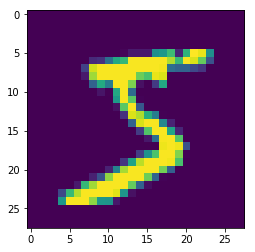

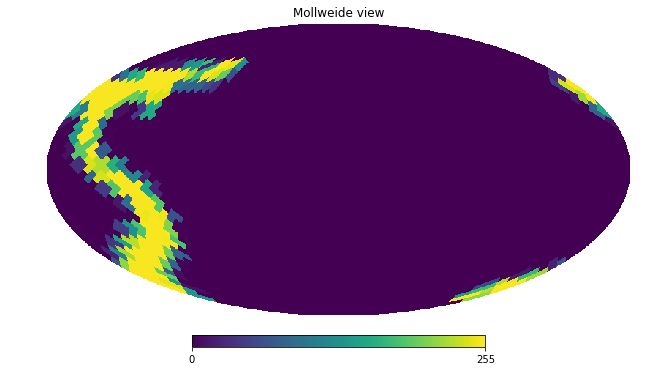

In [70]:
plt.imshow(X_train_temp[0])
hp.mollview(X_train_hp[0])

In [71]:
seed = 7
np.random.seed(seed)

In [72]:
X_train = X_train_hp.reshape(X_train_hp.shape[0], len(X_train_hp[0]), 1).astype('float32')
X_test = X_test_hp.reshape(X_test_hp.shape[0], len(X_train_hp[0]), 1).astype('float32')

In [73]:
X_train = X_train / 255
X_test = X_test / 255
num_classes = y_train.shape[1]
shape = (len(X_train_hp[0]), 1)
print(X_train.shape, shape, y_train.shape)

(10000, 3072, 1) (3072, 1) (10000, 10)


### Define NN architecture

In [74]:
inputs = keras.layers.Input(shape)
x = nnhealpix.layers.blocks.ConvNeighbours(nside, filters=32, kernel_size=9)(inputs)
x = keras.layers.Activation('relu')(x)
x = nnhealpix.layers.blocks.MaxPooling(nside, 8)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dense(num_classes)(x)
out = keras.layers.Activation('softmax')(x)
model = keras.models.Model(inputs=inputs, outputs=out)
model.compile(loss=keras.losses.mse, optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072, 1)           0         
_________________________________________________________________
order_map_11 (OrderMap)      (None, 27648, 1)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3072, 32)          288       
_________________________________________________________________
activation_31 (Activation)   (None, 3072, 32)          0         
_________________________________________________________________
order_map_12 (OrderMap)      (None, 3072, 32)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 768, 32)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 768, 32)           0         
__________

### ...and fit

In [75]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=200, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 10000 samples, validate on 100 samples
Epoch 1/2
10000/10000 [==============================] - 39s 4ms/step - loss: 0.0243 - acc: 0.8371 - val_loss: 0.0115 - val_acc: 0.9100
Epoch 2/2
10000/10000 [==============================] - 41s 4ms/step - loss: 0.0109 - acc: 0.9301 - val_loss: 0.0070 - val_acc: 0.9600
CNN Error: 4.00%


### Application of the same NN architecture to planar images
here we apply standard NN to the same dataset to compare the perfromances

In [54]:
X_train = X_train_temp.reshape(X_train_temp.shape[0], 1, 28, 28).astype('float32')
X_test = X_test_temp.reshape(X_test_temp.shape[0], 1, 28, 28).astype('float32')

In [55]:
seed = 7
np.random.seed(seed)

In [56]:
X_train = X_train / 255
X_test = X_test / 255
num_classes = y_test.shape[1]

In [57]:
inputs = keras.layers.Input((1,28,28))
x = keras.layers.Conv2D(32, (3, 3))(inputs)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dense(num_classes)(x)
out = keras.layers.Activation('softmax')(x)
model = keras.models.Model(inputs=inputs, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 26, 26)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 13, 13)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 13, 13)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               692352    
__________

In [58]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=200, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 10000 samples, validate on 100 samples
Epoch 1/2
10000/10000 [==============================] - 22s 2ms/step - loss: 0.6725 - acc: 0.8235 - val_loss: 0.2343 - val_acc: 0.8900
Epoch 2/2
10000/10000 [==============================] - 20s 2ms/step - loss: 0.2588 - acc: 0.9241 - val_loss: 0.1712 - val_acc: 0.9600
CNN Error: 4.00%


# Performances are comparable!
